In [29]:
import pandas as pd
import numpy as np
import time
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

This project analyses the black friday sales data from three Indian department stores. In addition to the total purchases it has the product category, store, and product ID of each purchase and demographic information about the purchaser. 

Here is a link to the data: [Black Friday](https://www.kaggle.com/mehdidag/black-friday). Here is the original posting of the data set from [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/black-friday/#problem_statement). The data posted on the website for use in a contest. The contest is to predict purchases and that will be one of the business questions I analyze in this notebook.  

## Business Understanding

In this analysis I ask three business questions:  

1\. Who is buying? What are the demographic characteristics of buyers and can we differentiate buyers by what we know about them personally?  Can we isolate groups that differ significantly in their purchasing behavior?  

2\. What are they buying? Can we differentiate customers by the product category they buy? We will focus in this section on gender.  

3\. How well can we predict sales? This is the question asked on the website that motivates the contest. We will see how much of the variance in total sales can be predicted from this data?  

[Here is a Medium Blogpost](https://medium.com/@michaelrobertreinhard/men-are-doing-the-shopping-depending-on-the-product-63393536595c) based on this analysis. 

## Data Understanding

In [30]:
import zipfile
zip_ref = zipfile.ZipFile("BlackFriday.csv.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [31]:
df = pd.read_csv('BlackFriday.csv', sep=',')

In [32]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [33]:
df.shape

(537577, 12)

In [34]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.375770e+05,537577.00000,537577.000000,537577.000000,370591.000000,164278.000000,537577.000000
mean,1.002992e+06,8.08271,0.408797,5.295546,9.842144,12.669840,9333.859853
std,1.714393e+03,6.52412,0.491612,3.750701,5.087259,4.124341,4981.022133
min,1.000001e+06,0.00000,0.000000,1.000000,2.000000,3.000000,185.000000
25%,1.001495e+06,2.00000,0.000000,1.000000,5.000000,9.000000,5866.000000
50%,1.003031e+06,7.00000,0.000000,5.000000,9.000000,14.000000,8062.000000
75%,1.004417e+06,14.00000,1.000000,8.000000,15.000000,16.000000,12073.000000
max,1.006040e+06,20.00000,1.000000,18.000000,18.000000,18.000000,23961.000000


In [35]:
df.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

## Data Preparation
As this data was taken from a contest it is, in the main, ready for analysis, but there are a few things that need to be done to it. The missing values have to be dealt with and some variables need their type adjusted.
### Missing Values
First I look for missing values. 

In [36]:
print(df.isna().sum())

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            166986
Product_Category_3            373299
Purchase                           0
dtype: int64


The missing values appear to be in the Product Categories 2 and 3. My guess is that these are the subcategories of product 1. That would explain why there are no missing values in Category 1. Dropping the values that are missing would result in over half of the data set being lost so that is not an option, so where they are missing I will just the product category 1. 

In [38]:
#substitue Product Category 1 for missing data in 2 and 3
df['Product_Category_2'] = df['Product_Category_2'].fillna(
    df['Product_Category_1']) 
df['Product_Category_3'] = df['Product_Category_3'].fillna(
    df['Product_Category_1']) 

### Mis-Typed data
There are some data that have the wrong type. For instance age is presently coded as a string variable becuase of the categories, like '0-17', '55+', it was coded into. For the categories that are bounded by two numbers I pick the median value. For the categories at the end of the data set pick reasonable values: 15 for 0-17 and 65 for 55+. 

In [39]:
df['Age'] = df['Age'].replace(
    {'0-17':int(15), 
     '55+':int(65),
     '18-25':int(22),
     '26-35':int(31),
     '36-45':int(41),
     '46-50':int(48),
     '51-55':int(53)})

The same is true for the number of years spent in current city, though this variable only codes up to a maximum of 4 years. 

In [40]:
df['Stay_In_Current_City_Years'].head()

0     2
1     2
2     2
3     2
4    4+
Name: Stay_In_Current_City_Years, dtype: object

In [41]:
#turn into an integer 
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].replace(
    {'0':int(0), 
     '1':int(1), 
     '2':int(2), 
     '3':int(3), 
     '4+':int(4)})

## Answering Business Questions

Though the data is not yet ready for machine learning I will interrupt data prep to answer the first two business questions. The problem is that I answer the first two business questions with descriptive statistics but I use the descriptive statistics to help determine how I will prep the data, specifically, which varaiables I will drop. So I will break the order here and intersperse the answering of the first two business questions before I conclude the data prep.

### 1) Are there differences between groups?
This is marketing data and the main use it can be put to is singling out groups for special marketing efforts. Therefore, the main group of hypotheses to test are whether there are differences in purchases among various groups. 

In [42]:
df.groupby('Occupation')['Purchase'].mean()

Occupation
0     9186.946726
1     9017.703095
2     9025.938982
3     9238.077277
4     9279.026742
5     9388.848978
6     9336.378620
7     9502.175276
8     9576.508530
9     8714.335934
10    9052.836410
11    9299.467190
12    9883.052460
13    9424.449391
14    9568.536426
15    9866.239925
16    9457.133118
17    9906.378997
18    9233.671418
19    8754.249162
20    8881.099514
Name: Purchase, dtype: float64

### Are the differences statistically significant?
That looks like some very small differences, too small to be statistically significant. But to be sure lets apply a t test to these differences. I first obtain the standart error for the group difference and then test to flag any group differences that are more than two standard deviations from the mean for the entire data set. 

In [45]:
#obtain standard deviations. 
mean = df['Purchase'].mean()
standard_deviation = df['Purchase'].std()

In [46]:
#check if any occupational groups are more than two standard 
#deviations from the mean for purchases.
sig_occ_groups = []
for occ_group in df.groupby('Occupation')['Purchase'].mean():
#     print(abs(mean - 2*standard_deviation) < abs(mean - occ_group))
    if abs(mean - 2*standard_deviation) < abs(mean - occ_group):
        sig_occ_groups.append(occ_group)

In [47]:
#print results
print(sig_occ_groups)

[]


So the first business hypothesis, that purchases differ significantly by occupation, is shown to be false.  

### Automating the procedure

But this exercise points to a procedure that could be usefully automated. We seek to find any groups that differ in a statistically significant way from the mean of the data set in purchases. Why not make the above procedure a functtion that could be applied to all of the groups in the data set? That is what I am going to do. The function will take a category of consumers, group the data set by them, and then test to see if the groups differ from the data set mean in a statistically significant way.  

I will assume the data set mean and standard deviations to be globally available to the data set in this analysis.

In [55]:
#automating testing for statistically significant differences
def group_diff(df, group, mean, std_dev):
    '''Automate discovery of group differences.
    
    Takes the name of a group, e.g., "gender", and checks to see if 
    its values, in this case "male" and "female", are associated with 
    statistically significant differences in values on the dependent
    variable, in this case, "Purchase".
    
    Parameters:  
    arg1 (DataFrame): the DataFrame  
    
    arg2 (str or list of strs): The grouping variable(s)  
    
    arg3 (float): The mean of the dependent variable
    
    arg4 (float): The standard deviation of the dependent variable
    
    Returns:
    list: values of the grouping variable which are associated with
    a statistically significant difference.'''
    sig_groups = []
    for index, group_mean in enumerate(df.groupby(group)['Purchase'].mean()):
        if abs(mean - 2*std_dev) < abs(mean - group_mean):
            sig_groups.append(index)
    return sig_groups

In [56]:
occupation_groups = group_diff(df=df, group='Gender', 
                               mean=df['Purchase'].mean(), 
                               std_dev=df['Purchase'].std())
print(occupation_groups)

[]


In [57]:
gender_groups = group_diff(df=df, group='Gender', 
                           mean=df['Purchase'].mean(), 
                           std_dev=df['Purchase'].std())
print(gender_groups)

[]


In [58]:
city_groups = group_diff(df=df, group='City_Category', 
                         mean=df['Purchase'].mean(), 
                         std_dev=df['Purchase'].std())
print(city_groups)

[]


In [59]:
marital_groups = group_diff(df=df, group='Marital_Status', 
                         mean=df['Purchase'].mean(), 
                         std_dev=df['Purchase'].std())
print(marital_groups)

[]


In [60]:
#We can give groupby lists allowing up to test subgroups
gender_maritalStatus_groups = group_diff(df=df, group=['Gender', 'Marital_Status'], 
                                         mean=df['Purchase'].mean(), 
                                         std_dev=df['Purchase'].std())

print(gender_maritalStatus_groups)

[]


In [61]:
Age_groups = group_diff(df=df, group='Age', 
                        mean=df['Purchase'].mean(), 
                        std_dev=df['Purchase'].std())
print(Age_groups)

[]


So this gives a fuller answer to our first business question, are there any significant differences between groups in their purchases? The answer is no, at least for this data set. In all the demographic groups we have the differences in mean purchases by group are not statistically significant. 

## What are they buying?
### 2) Are there differeince between Product Categories
But if there are no statistically significant differences between groups in the average amount of purchases they make, does that hold true for every product category? Here I will only ask the question for one demographic distinction: gender.

In [62]:
male_means = df[df['Gender']=='M'].groupby(['Product_Category_1', 
                                            'Gender'])['Purchase'].count()\
                                            /len(df[df['Gender']=='M'])
    
female_means = df[df['Gender']=='F'].groupby(['Product_Category_1', 
                                              'Gender'])['Purchase'].count()\
                                              /len(df[df['Gender']=='F'])

male_stderr = df[df['Gender']=='M'].groupby(['Product_Category_1', 
                                             'Gender'])['Purchase'].std()\
                                             /len(df[df['Gender']=='M'])
    
female_stderr = df[df['Gender']=='F'].groupby(['Product_Category_1', 
                                               'Gender'])['Purchase'].std()\
                                               /len(df[df['Gender']=='F'])

<Figure size 432x288 with 0 Axes>

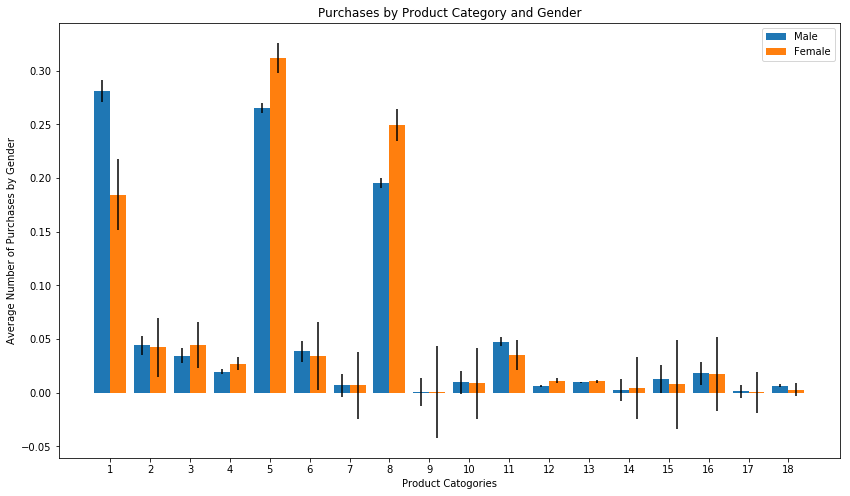

In [63]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

plt.clf()

fig, ax = plt.subplots()

ind = df['Product_Category_1'].unique()
ind = np.array(sorted(ind))

fig.set_size_inches(14, 8)

width = 0.40  

p1 = plt.bar(ind, male_means, width, yerr=male_stderr, label='Male')
p2 = plt.bar(ind + width, female_means, width, yerr=female_stderr, label='Female')

ax.set_xlabel('Product Catogories')
ax.set_ylabel('Average Number of Purchases by Gender')
plt.title('Purchases by Product Category and Gender')
ax.set_xticks(ind + width/2)
ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18'))

plt.legend();

Now we can see the differences between the purchases of men and women by product category. We can see by the overlap of the error bars that the differences are not statistically significant in all but three categories, the three with the greatest differences in the means for men and women. Lets adjust our chart to emphasize those three categories of product purchases.

In [64]:
diff = male_means.values - female_means.values

In [65]:
orig_dict = {}
for i,j in zip([x for x in range(1,19)],diff):
    orig_dict[i] = j
print(orig_dict)

{1: 0.09651862748908485, 2: 0.002063456634068879, 3: -0.009959859063205803, 4: -0.007298044412406009, 5: -0.046729189605491606, 6: 0.004850963550286691, 7: -0.0002607362347784737, 8: -0.05389129212015187, 9: 0.00029440552627554113, 10: 0.0009974371746762044, 11: 0.01236925977507932, 12: -0.005457907923230989, 13: -0.0009051736895549639, 14: -0.002448948541964582, 15: 0.005039683148197288, 16: 0.00021682876831089284, 17: 0.0007867789956068137, 18: 0.0038137105291977773}


In [66]:
ord_dict = OrderedDict()
for i,j in zip(diff, [x for x in range(1,19)]):
    ord_dict[i] = j
print(ord_dict)

OrderedDict([(0.09651862748908485, 1), (0.002063456634068879, 2), (-0.009959859063205803, 3), (-0.007298044412406009, 4), (-0.046729189605491606, 5), (0.004850963550286691, 6), (-0.0002607362347784737, 7), (-0.05389129212015187, 8), (0.00029440552627554113, 9), (0.0009974371746762044, 10), (0.01236925977507932, 11), (-0.005457907923230989, 12), (-0.0009051736895549639, 13), (-0.002448948541964582, 14), (0.005039683148197288, 15), (0.00021682876831089284, 16), (0.0007867789956068137, 17), (0.0038137105291977773, 18)])


Now I have the values in an ordered dict with their indexes, the category numbers, as thier values. Next, I want to create a new dictionary with those same values as keys, but this time with thier absolute values. 

In [67]:
abs_val_dict = dict()
for key, value in ord_dict.items():
    abs_val_dict[abs(key)] = value
print(abs_val_dict)

{0.09651862748908485: 1, 0.002063456634068879: 2, 0.009959859063205803: 3, 0.007298044412406009: 4, 0.046729189605491606: 5, 0.004850963550286691: 6, 0.0002607362347784737: 7, 0.05389129212015187: 8, 0.00029440552627554113: 9, 0.0009974371746762044: 10, 0.01236925977507932: 11, 0.005457907923230989: 12, 0.0009051736895549639: 13, 0.002448948541964582: 14, 0.005039683148197288: 15, 0.00021682876831089284: 16, 0.0007867789956068137: 17, 0.0038137105291977773: 18}


Now I use the absolute values to sort the dictionary values by the absolute value of their keys and I will save this to another data structure.

In [68]:
category_list = []
for i in sorted(abs_val_dict.keys(),reverse=True):
    category_list.append(abs_val_dict[i])
print(category_list)

[1, 8, 5, 11, 3, 4, 12, 15, 6, 18, 14, 2, 10, 13, 17, 9, 7, 16]


Then I use this list of category names to get the original values.

In [69]:
values = []
for i in category_list:
    values.append(orig_dict[i])

values_arr = np.array(values)
category_arr = np.array(category_list)

In [70]:
category_arr_str = [str(i) for i in category_arr]

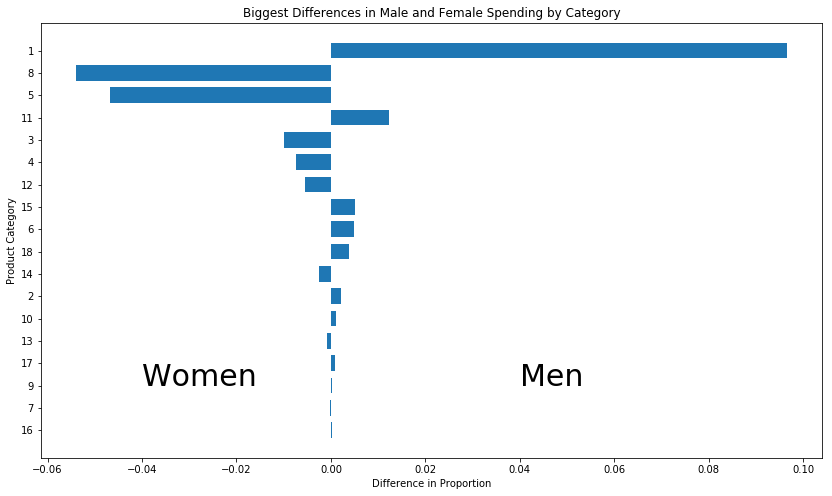

In [71]:
plt.clf()
plt.cla()

fig = plt.gcf()

fig.set_size_inches(14, 8)

width = 0.70

plt.barh(category_arr_str[::-1], values_arr[::-1], width)
plt.xlabel('Difference in Proportion')
plt.xticks=category_arr_str


plt.ylabel('Product Category')


plt.annotate(xy = [-0.04, 2], s='Women', fontsize=30)
plt.annotate(xy = [0.04, 2], s='Men', fontsize=30)
plt.title('Biggest Differences in Male and Female Spending by Category');

So from this graph it is easy to see that product category 1 is favored by men by a nearly 10% margin, while categories 8 and 5 are favored by women by around 5%. This is something to be taken into account in business decisions. 

## Data prep continued: Prep for machine learning

Create the target variable.

In [72]:
y = df['Purchase']

### Drop unused variables
Now that we have put purchase in the 'y' or target data we have to get rid of it. I experimented with leaving out other variables and so wrote a function that defaults to removing 'purchase', 'User_ID', and 'Product_ID'. I left these out because they are not really general enough to provide an real insights to policy. Predicting how much a person spend from the product they bought is largely an exercise in predicting the price of the product. The same problem presents itself with the User_ID. We can predict the individual's behavior but can't generalise from that without knowing some characteristics that person shares with other. 

In [73]:
#make a function to drop unused categories
def drop_col(df, use_product_factor=False, category=False):
    '''drop categories that are unused, making User_ID 
       and Product_ID optional and making Product_Category_ID optional'''
    
    if use_product_factor:   
        my_list = ['Purchase', 
                   'User_ID', 
                   'Product_ID']
    else:
        my_list = ['Purchase']
    
    if category:
        my_list.extend(['Product_Category_1', 
                        'Product_Category_2', 
                        'Product_Category_3'])
    
    for col in my_list:
        try:
            df.drop(col, inplace=True, axis=1)
        except:
            'column has already been deleted'

In [74]:
drop_col(df)

### Prepare list of qualitative variables
The next thing we have to do is get the qualitative variables into a data frame that we can work with. Here I have created a function that defaults to four qualitative variables and includes the option to add product ID and the Product Categories. I have found that the default is the most informative.

In [75]:
def select_qual_var(df, Product_ID=False, Product_Category=True):
    '''creates list of qualitative variables. Includes product category and
    excludes Product_ID by default'''
    
    my_list = ['Occupation', 'Marital_Status', 'Gender', 'City_Category']
    
    if Product_ID==True:
        my_list.append('Product_ID')
    if Product_Category==True:
        my_list.extend(['Product_Category_1', 'Product_Category_2', 'Product_Category_3'])
    df_qual = df.loc[:, my_list]
    
    return df_qual

In [76]:
df_qual = select_qual_var(df)

### Get dummies
Now I have to get the dummy variables from the qualitative variables and drop the original qualitative variables. I do this in a for loop. 

In [77]:
#make dummy variables of the qualitative variables
#and drop the original variable
for var in df_qual.columns:
    df_qual = pd.concat(
                [df_qual.drop(var, axis=1), 
                 pd.get_dummies(df_qual[var], 
                   drop_first=True, 
                   prefix=var, 
                   prefix_sep='_')], 
                 axis=1)

In [78]:
df_qual.shape

(537577, 75)

### Get quantitative variables

In [79]:
df_quant = df.select_dtypes(['float', 'int'])

In [80]:
df_quant.columns

Index(['User_ID', 'Age', 'Occupation', 'Stay_In_Current_City_Years',
       'Marital_Status', 'Product_Category_1', 'Product_Category_2',
       'Product_Category_3'],
      dtype='object')

### Join the two data frames

In [81]:
df = df_quant.join(df_qual)

### Train test split
I create a function to do this because I wanted to use a sample of the data frame for experimentation. 

In [82]:
def get_train_test_split(df, y, sample=False):
    '''performs train_test_split with option to 
    create a smaller sample data set of 5000.'''
    
    if sample:
        df = df.sample(n=5000, random_state=42)
        y = y.sample(n=5000, random_state=42)
    
    X = df
    y = y
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [83]:
X_train, X_test, y_train, y_test = get_train_test_split(df, y)

### Scale the variables

In [84]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

## Modeling
I finally present the final model to answer the question how well can we predict purchases. I have left the trial and error for the notebook "Black Friday", included in this repository. There I went through Linear Regression and it regularized variants, lasso and ridge regression, and finally onto Random Forest Regression, the results of which, I present here.  

Using grid search, I manipulated the maximum depth, features, and leaf nodes, as well as the minimum samples to form a leaf and the number of estimators. I present the results of the best model here. 

There was little loss in performance of the model from the training to the test data, with the $R^2$ dropping from 65.20 to 65.07. That means we can explain 65% of the variance in purchases by the model. 

In [53]:
params={'max_depth': [21], 'max_features': [69], 'max_leaf_nodes': [695],
        'min_samples_leaf': [1], 'n_estimators': [500]}
cv = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                  param_grid=params, verbose=1, cv=3, n_jobs=-1)


In [54]:
t0 = time.time()

results = cv.fit(X_train,y_train)

t1 = time.time()

total = t1 - t0
print(total/60)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 56.2min finished


90.16744508345921


In [55]:
print(results.best_estimator_)
print(results.best_score_)
print(results.best_params_)
y_test_pred = cv.predict(X_test)

print(r2_score(y_test, y_test_pred))
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
           max_features=69, max_leaf_nodes=695, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
0.6573656257603486
{'max_depth': 21, 'max_features': 69, 'max_leaf_nodes': 695, 'min_samples_leaf': 1, 'n_estimators': 500}
0.6564416792437611
2919.19479957651


## Evaluation
We were able to get the $R^2$ on the testing set up to 0.656 and the mean squared error down to 2919. That is pretty good but the leader board on the contest has mean squared error 2405. 2919 doesn't occur untill the 3rd page of results. I don't know why they are doing so much better than me. One possibility is that they are using Product_ID. I excluded this variable on the grounds that it was just predicting the price of the product and would have limited use for business decisions but maybe for the contest it might be worth it.  

In any case we have shown that the data set shows no statistically significant differences between groups in their overall purchases which is surprising. On the other hand, we were able to find three product groups that have different amounts bought between men and women, a fact which might be useful to marketers.